In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Importing Libraries and Modules

In [0]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from geopy.distance import great_circle
import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split

from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, RandomizedSearchCV

from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE


## Loading the Datasets

In [0]:
## Loading the Datasets
train = pd.read_csv('drive/My Drive/ML/data/weka_processed/train_pro.csv')
test = pd.read_csv('drive/My Drive/ML/data/test.csv')


## Basic Intuition on the Data

In [37]:
train.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
0,189123628,10.5,834,56,0,64,'11/1/2019 0:20','11/1/2019 0:34',6.86252,79.8993,6.90330,79.8783,270.32,correct
1,189125358,10.5,791,47,0,134,'11/1/2019 0:56','11/1/2019 1:09',6.88589,79.8984,6.91373,79.8923,197.85,correct
2,189125719,10.5,1087,80,0,61,'11/1/2019 1:08','11/1/2019 1:26',6.90839,79.8651,6.93669,79.9146,301.64,correct
3,189127273,10.5,598,271,15.6638,68,'11/1/2019 2:27','11/1/2019 2:37',6.92570,79.8895,6.92748,79.8971,82.3,correct
4,189128020,?,?,?,?,?,'11/1/2019 3:34','11/1/2019 3:51',6.87441,79.8615,6.84478,79.9290,358.39,correct


In [38]:
test.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare
0,213284604,10.5,924,42,2.4486,148,2/1/2020 0:38,2/1/2020 0:53,6.83454,79.8750,6.77490,79.8840,289.27
1,213286352,10.5,4249,20,0.0000,91,2/1/2020 1:02,2/1/2020 2:13,6.91168,79.8723,6.55091,79.9706,1912.70
2,213293973,10.5,1552,255,2.6588,23,2/1/2020 5:02,2/1/2020 5:28,6.92145,79.8478,6.90539,79.8989,394.00
3,213294622,10.5,462,16,0.0000,198,2/1/2020 5:30,2/1/2020 5:38,6.77433,79.9416,6.80401,79.9407,154.32
4,213298687,10.5,814,392,12.3692,69,2/1/2020 7:00,2/1/2020 7:14,6.97968,79.9130,6.98875,79.8914,147.47


In [39]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15327 entries, 0 to 15326
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   tripid                     15327 non-null  int64  
 1   additional_fare            15327 non-null  object 
 2   duration                   15327 non-null  object 
 3   meter_waiting              15327 non-null  object 
 4   meter_waiting_fare         15327 non-null  object 
 5   meter_waiting_till_pickup  15327 non-null  object 
 6   pickup_time                15327 non-null  object 
 7   drop_time                  15327 non-null  object 
 8   pick_lat                   15327 non-null  float64
 9   pick_lon                   15327 non-null  float64
 10  drop_lat                   15327 non-null  float64
 11  drop_lon                   15327 non-null  float64
 12  fare                       15327 non-null  object 
 13  label                      15327 non-null  obj

In [40]:
train.shape

(15327, 14)

In [41]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8576 entries, 0 to 8575
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   tripid                     8576 non-null   int64  
 1   additional_fare            8576 non-null   float64
 2   duration                   8576 non-null   int64  
 3   meter_waiting              8576 non-null   int64  
 4   meter_waiting_fare         8576 non-null   float64
 5   meter_waiting_till_pickup  8576 non-null   int64  
 6   pickup_time                8576 non-null   object 
 7   drop_time                  8576 non-null   object 
 8   pick_lat                   8576 non-null   float64
 9   pick_lon                   8576 non-null   float64
 10  drop_lat                   8576 non-null   float64
 11  drop_lon                   8576 non-null   float64
 12  fare                       8576 non-null   float64
dtypes: float64(7), int64(4), object(2)
memory usage:

In [42]:
test.shape

(8576, 13)

## Cleaning the Data

In [0]:
## cleaning weka added unnecessary values

train = train.replace({'?': np.nan})


In [0]:
## converting label values into 0,1 instead of correct, incorrect

train.label = train.label.map(dict(correct=1, incorrect=0))

In [45]:
## check for missing values in the dataset

# train.isna().head()
train.isna().sum()

tripid                         0
additional_fare              196
duration                     196
meter_waiting                196
meter_waiting_fare           196
meter_waiting_till_pickup    196
pickup_time                    0
drop_time                      0
pick_lat                       0
pick_lon                       0
drop_lat                       0
drop_lon                       0
fare                         133
label                          0
dtype: int64

In [46]:
test.isna().sum()

tripid                       0
additional_fare              0
duration                     0
meter_waiting                0
meter_waiting_fare           0
meter_waiting_till_pickup    0
pickup_time                  0
drop_time                    0
pick_lat                     0
pick_lon                     0
drop_lat                     0
drop_lon                     0
fare                         0
dtype: int64

In [0]:
## fill missing values by mean of the column

# train.fillna(train.mean(), inplace=True)

# imputer = IterativeImputer(max_iter=10, random_state=42)
# imputer.fit(train.iloc[:,[1,2,3,4,5,12]])
# train.iloc[:,[1,2,3,4,5,12]] = imputer.transform(train.iloc[:,[1,2,3,4,5,12]])

imputer = KNNImputer(n_neighbors=5, weights='uniform')
train.iloc[:,[1,2,3,4,5,12]] = imputer.fit_transform(train.iloc[:,[1,2,3,4,5,12]])


In [48]:
train.isna().sum()

tripid                       0
additional_fare              0
duration                     0
meter_waiting                0
meter_waiting_fare           0
meter_waiting_till_pickup    0
pickup_time                  0
drop_time                    0
pick_lat                     0
pick_lon                     0
drop_lat                     0
drop_lon                     0
fare                         0
label                        0
dtype: int64

In [0]:
## Dropping date columns
train.drop(['pickup_time', 'drop_time'], axis=1, inplace=True)
test.drop(['pickup_time', 'drop_time'], axis=1, inplace=True)


## Basic Feature Engineering

In [0]:
## Join train and test datasets in order to obtain the same number of features during categorical conversion
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)


## Advanced Feature Engineering

## Feature Preprocessing

In [0]:
## Scaling values into 0-1 range

scaler = MinMaxScaler(feature_range=(0,1))
features = [
    'additional_fare',
    'duration',
    'meter_waiting',
    'meter_waiting_fare',
    'meter_waiting_till_pickup',
    'pick_lat',
    'pick_lon',
    'drop_lat',
    'drop_lon',
    'fare'
]

dataset[features] = scaler.fit_transform(dataset[features])


In [0]:
## Split into training and testing again

train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=['label'], axis=1, inplace=True)

train['label'] = train['label'].astype(int)


In [0]:
## Drop unnecessary columns
labels_to_drop = [
    'tripid',
#     'pick_lat',
#     'pick_lon',
#     'drop_lat',
#     'drop_lon',
    # 'pickup_time',
    # 'drop_time'
]

train.drop(labels=labels_to_drop, axis=1, inplace=True)


## Feature Importance

In [54]:
y = train['label']
X = train.drop(labels=['label'], axis=1)

# apply SelectKBest class to extract top 20 best features
bestfeatures = SelectKBest(score_func=chi2, k='all')
fit = bestfeatures.fit(X, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']  #naming the dataframe columns
print(featureScores.nlargest(30, 'Score'))  #print 10 best features


                       Specs      Score
3         meter_waiting_fare  45.763162
2              meter_waiting  41.708268
9                       fare  16.321160
1                   duration  15.022474
6                   pick_lon   7.465128
0            additional_fare   1.522073
4  meter_waiting_till_pickup   0.240755
5                   pick_lat   0.161323
7                   drop_lat   0.006369
8                   drop_lon   0.001578


In [0]:
# ## Drop less important columns
# labels_to_drop = [
#     'drop_lon',
#     'drop_lat',
# ]

# train.drop(labels=labels_to_drop, axis=1, inplace=True)


## Train for the Selected Model

In [0]:
## function to calculate F1 score
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true*y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val


In [26]:
train.shape

(15327, 11)

In [0]:
## Seperate train features and label

y = train['label']
X = train.drop(labels='label', axis=1)

# ## Spliting into training and testing
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [0]:
# kfold = StratifiedKFold(n_splits=20, random_state=42, shuffle=False)


In [28]:
## define the keras model
model = Sequential()

# model.add(Dense(36, input_dim=23, activation='relu'))
# model.add(Dense(18, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
# # loss: 0.1550 - get_f1: 0.9739
# Accuracy: 97.1872

# model.add(Dense(36, input_dim=23, activation='relu'))
# model.add(Dense(12, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
# # loss: 0.1517 - get_f1: 0.9754
# # Accuracy: 97.5980

# model.add(Dense(36, input_dim=23, activation='relu'))
# model.add(Dense(18, activation='relu'))
# model.add(Dense(9, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
# # loss: 0.1497 - get_f1: 0.9746
# # Accuracy: 97.6440

# model.add(Dropout(0.2, input_shape=(23,)))
# model.add(Dense(18, activation='relu'))
# model.add(Dense(9, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
# # loss: 0.2449 - get_f1: 0.9565
# # Accuracy: 95.7522

# model.add(Dense(36, input_dim=23, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(18, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(9, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(1, activation='sigmoid'))
# # loss: 0.1918 - get_f1: 0.9674
# # Accuracy: 97.1700

# model.add(Dense(23, input_dim=23, activation='relu'))
# model.add(Dense(12, activation='relu'))
# model.add(Dense(6, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
# # loss: 0.1568 - get_f1: 0.9736
# # Accuracy: 97.5273


model.add(Dense(10, input_dim=10, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# loss: 0.1680 - f1_score: 0.9686 - val_loss: 0.1758 - val_f1_score: 0.9648
# Accuracy: 97.5273


## compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_score])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________


In [0]:
# early stopping and model checkpoint
es = EarlyStopping(
    monitor='val_loss',
    mode='min',
    verbose=1,
    patience=200
)

mc = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True
)

In [0]:
## fit the keras model on the dataset
history = model.fit(
    X,
    y,
    epochs=1000,
    batch_size=20,
    # validation_data=(X_test, y_test),
    validation_split=0.2,
    shuffle=True,
    callbacks=[es,mc]
)


In [0]:
## saving the best model

!cp 'best_model.h5' "drive/My Drive/ML/models/"

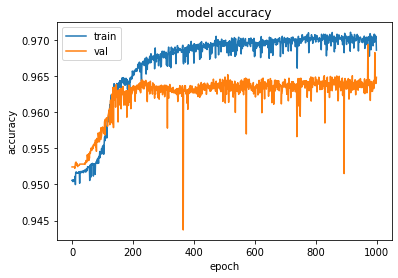

In [31]:
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

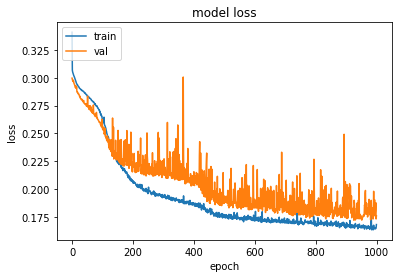

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
## load the saved best model
# saved_model = load_model('drive/My Drive/ML/models/best_model.h5')

## evaluate the keras model
# _, accuracy = model.evaluate(X_test, y_test)
# print('Accuracy: %.4f' % (accuracy * 100))


In [34]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8576 entries, 15327 to 23902
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   tripid                     8576 non-null   int64  
 1   additional_fare            8576 non-null   float64
 2   duration                   8576 non-null   float64
 3   meter_waiting              8576 non-null   float64
 4   meter_waiting_fare         8576 non-null   float64
 5   meter_waiting_till_pickup  8576 non-null   float64
 6   pick_lat                   8576 non-null   float64
 7   pick_lon                   8576 non-null   float64
 8   drop_lat                   8576 non-null   float64
 9   drop_lon                   8576 non-null   float64
 10  fare                       8576 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 737.1 KB


## Predicting and Preparing the Submission

In [0]:
trip_ids = test.tripid

labels_to_drop = [
    'tripid'
]

test = test.drop(labels=labels_to_drop, axis=1)


In [57]:
## make probability predictions with the model
# predictions = model.predict(test)
# # round predictions
# rounded = [round(x[0]) for x in predictions]


## make class predictions with the model
predictions = model.predict_classes(test)

pred_list = []
for pred in predictions:
    pred_list.append(pred[0])

output = pd.DataFrame({'tripid': trip_ids, 'prediction': pred_list})
output.to_csv('160253h_submission_12.csv', index=False)

!cp '160253h_submission_12.csv' "drive/My Drive/ML/submissions/"

print('Completed!')


Completed!


model training.

remove outliers only (-Weka).

KNNImputer to impute missing values.

without feature engineering.

datetime columns have dropped.

[model: Neural Network]

score: 0.97587
